In [1]:
## Pour Colab
# !pip install -U -q PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

### Download datasets (pour Colab)
#downloaded = drive.CreateFile({'id':"1t5wi4xjrOD5OcxH3SMhTNH9wxRuU5dMb"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('NKAS_Raman.hdf5')  

#downloaded = drive.CreateFile({'id':"1s62a9Tfgmht0lUCjlAwVjW56vbngWE26"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('DataSet_0p20val.hdf5')  

#downloaded = drive.CreateFile({'id':"1FxLvyBgmfQ17xctfOjzEvWcNmGa9F4sR"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('NKAS_density.hdf5')  

#downloaded = drive.CreateFile({'id':"1AyFwtkEzhH01clvoo9Y5_unGfeMM8Q1E"})   # replace the id with id of file you want to access
#downloaded.GetContentFile('neuravi.py')  

In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import time

from sklearn.metrics import mean_squared_error
import h5py

# Check torch install
try:
  import torch
except:
  print("Starting a session, torch not installed, installing...")
  !pip3 install torch # we install torch if not installed
  import torch

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  True
cuda


# Load data and run on device

In [2]:
# load neuravi
import neuravi

### Load dataset

ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",device)

# Network declaration
neuralmodel = neuravi.model(4,200,5,ds.nb_channels_raman,p_drop=0.2) 

# criterion for match
criterion = torch.nn.MSELoss()
criterion.to(device)
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer

# we initialize the output bias
neuralmodel.output_bias_init()

# we send the neural net on device
neuralmodel.to(device)

# To see how the model is improving, 
# we can check the test loss before the model training and compare it with the test loss after the training.
neuralmodel.eval()
y_ag_pred_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
y_ag_pred_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)

y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train,ds.lbd_ri_train)
y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid,ds.lbd_ri_valid)

ag_before_train = criterion(y_ag_pred_train, ds.y_visco_train)
ag_before_valid = criterion(y_ag_pred_valid, ds.y_visco_valid)
print('Train loss before training' , ag_before_train.item())
print('Valid loss before training' , ag_before_valid.item())

ri_before_train = criterion(y_ri_pred_train, ds.y_ri_train)
ri_before_valid = criterion(y_ri_pred_valid, ds.y_ri_valid)
print('Train loss before training' , ri_before_train.item())
print('Valid loss before training' , ri_before_valid.item())

neuralmodel

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Train loss before training 30.053197860717773
Valid loss before training 14.523977279663086
Train loss before training 0.0011561961146071553
Valid loss before training 0.001139101106673479


model(
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=200, bias=True)
  )
  (out_thermo): Linear(in_features=200, out_features=15, bias=True)
  (out_raman): Linear(in_features=200, out_features=850, bias=True)
)

# Pretraining!

Pretrain...

Epoch 0 => train loss: 2.1384146213531494; valid loss: 3.943140983581543
Epoch 100 => train loss: 1.8109817504882812; valid loss: 3.9212915897369385
Running time in seconds: 4.0197272300720215


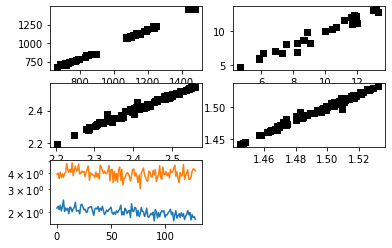

In [5]:
neuralmodel, record_pretrain_loss, record_prevalid_loss = neuravi.pretraining(neuralmodel,ds,criterion,optimizer)

neuralmodel.eval() # putting the network in eval mode and looking at pretrained training results

plt.subplot(3,2,1)
plt.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_train).cpu().detach().numpy(),"ks",label="Train")

plt.subplot(3,2,2)
plt.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_train).cpu().detach().numpy(),"ks")

plt.subplot(3,2,3)
plt.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.density(ds.x_density_train).cpu().detach().numpy(),"ks")

plt.subplot(3,2,4)
plt.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.sellmeier(ds.x_ri_train,ds.lbd_ri_train).cpu().detach().numpy(),"ks")


plt.subplot(3,2,5)
plt.plot(record_pretrain_loss)
plt.plot(record_prevalid_loss)
plt.yscale('log')

In [8]:
y_ri_pred_train = neuralmodel.sellmeier(ds.x_ri_train,ds.lbd_ri_train)
y_ri_pred_valid = neuralmodel.sellmeier(ds.x_ri_valid,ds.lbd_ri_valid)

ag_before_train = criterion(y_ag_pred_train, ds.y_visco_train)
ag_before_valid = criterion(y_ag_pred_valid, ds.y_visco_valid)
print('Train loss before training' , ag_before_train.item())
print('Valid loss before training' , ag_before_valid.item())

ri_before_train = criterion(y_ri_pred_train, ds.y_ri_train)
ri_before_valid = criterion(y_ri_pred_valid, ds.y_ri_valid)
print('Train loss before training' , ri_before_train.item())
print('Valid loss before training' , ri_before_valid.item())


Train loss before training 34.902984619140625
Valid loss before training 15.836901664733887
Train loss before training 1.516458905825857e-05
Valid loss before training 1.365382740914356e-05


# Training

In [4]:
neuralmodel, record_train_loss, record_valid_loss = neuravi.maintraining(neuralmodel,
                                                                         ds,
                                                                         criterion,optimizer,
                                                                         "./model/model.pth",verbose=True,
                                                                         train_patience=50)

Epoch 0 => train loss: 11.395855903625488; valid loss: 13.099912643432617
Epoch 200 => train loss: 2.683927297592163; valid loss: 4.646543025970459
Running time in seconds: 15.779110193252563


# Loss function plot

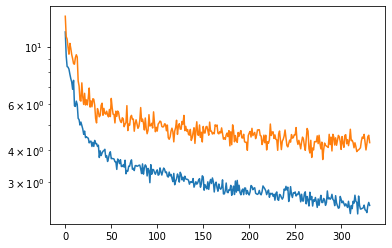

In [6]:
plt.plot(record_train_loss)
plt.plot(record_valid_loss)
plt.yscale('log')

# upload on Google Drive
#file_out = drive.CreateFile()
# Read file and set it as a content of this instance.
#file_out.SetContentFile("model.pth")
#file_out.Upload() # Upload the file.

# Post-training evaluations

In [8]:
neuralmodel.eval()
y_ag_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)

ag_after_train = criterion(y_ag_train, ds.y_visco_train)
ag_after_valid = criterion(y_ag_valid, ds.y_visco_valid)
ag_after_test = criterion(y_ag_test, ds.y_visco_test)
print('AG train loss after training' , ag_after_train.item())
print('AG valid loss after training' , ag_after_valid.item())
print('AG test loss after training' , ag_after_test.item())
print('')
myega_after_train = criterion(y_myega_train, ds.y_visco_train)
myega_after_valid = criterion(y_myega_valid, ds.y_visco_valid)
myega_after_test = criterion(y_myega_test, ds.y_visco_test)
print('MYEGA train loss after training' , myega_after_train.item())
print('MYEGA valid loss after training' , myega_after_valid.item())
print('MYEGA test loss after training' , myega_after_test.item())
print('')
am_after_train = criterion(y_am_train, ds.y_visco_train)
am_after_valid = criterion(y_am_valid, ds.y_visco_valid)
am_after_test = criterion(y_am_test, ds.y_visco_test)
print('am train loss after training' , am_after_train.item())
print('am valid loss after training' , am_after_valid.item())
print('am test loss after training' , am_after_test.item())

AG train loss after training 0.4985491931438446
AG valid loss after training 0.43454718589782715
AG test loss after training 0.4872213900089264

MYEGA train loss after training 0.4911558926105499
MYEGA valid loss after training 0.5390592813491821
MYEGA test loss after training 0.4151292145252228

am train loss after training 0.29774385690689087
am valid loss after training 0.24822162091732025
am test loss after training 0.29778334498405457


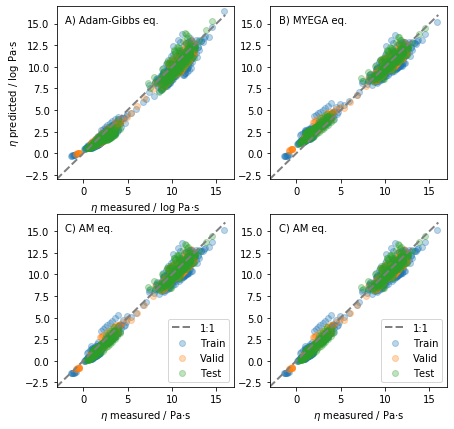

In [9]:
plt.figure(figsize=(7,7))

plt.subplot(2,2,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xlabel("$\eta$ measured / log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted / log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

#plt.legend(loc=4)

plt.subplot(2,2,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("B) MYEGA eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("C) AM eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc=4)

plt.xlabel("$\eta$ measured / Pa$\cdot$s")


plt.subplot(2,2,4)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("C) AM eq.",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc=4)

plt.xlabel("$\eta$ measured / Pa$\cdot$s")
plt.show()

<ErrorbarContainer object of 3 artists>

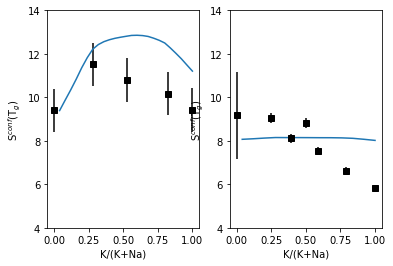

In [10]:
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.subplot(1,2,1)
plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.sctg(torch.Tensor(X_visu_).to(device)).cpu().detach().numpy(),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

plt.subplot(1,2,2)
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.sctg(torch.Tensor(X_visu_).to(device)).cpu().detach().numpy(),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="ks",
    label="Le Losq et al., 2017")

Checking shape...
(50, 4)


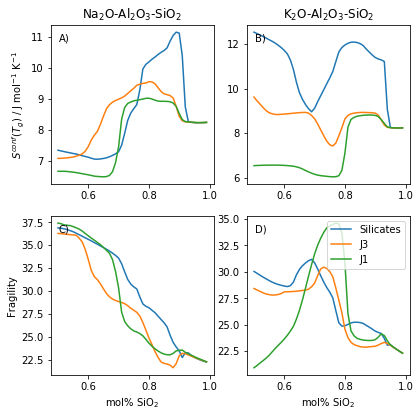

In [10]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T
print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],neuralmodel.sctg(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],neuralmodel.sctg(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],neuralmodel.sctg(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")


plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],neuralmodel.sctg(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],neuralmodel.sctg(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],neuralmodel.sctg(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],neuralmodel.fragility(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],neuralmodel.fragility(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],neuralmodel.fragility(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#plt.ylim(17,60)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],neuralmodel.fragility(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy(),color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],neuralmodel.fragility(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy(),color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],neuralmodel.fragility(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy(),color="C2",label="J1")
#plt.ylim(17,60)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

NameError: name 'y_tg_train' is not defined

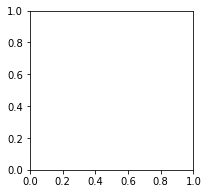

In [11]:
plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1)
plt.plot(y_tg_train.cpu().detach().numpy(),neuralmodel.tg(x_tg_train).cpu().detach().numpy(),marker="s",linestyle="none",color="C0",alpha=0.3,label="Train")
plt.plot(y_tg_valid.cpu().detach().numpy(),neuralmodel.tg(x_tg_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(y_tg_test.cpu().detach().numpy(),neuralmodel.tg(x_tg_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="Test")

plt.ylabel("Predicted")
plt.title(r"A) $T_g$ / K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(x_entro_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(y_entro_valid.cpu().detach().numpy(),neuralmodel.sctg(x_entro_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(y_entro_test.cpu().detach().numpy(),neuralmodel.sctg(x_entro_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")

plt.title(r"C) $S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")

plt.plot([4,12],[4,12],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,3)
plt.plot(y_density_train.cpu().detach().numpy(),neuralmodel.density(x_density_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(y_density_valid.cpu().detach().numpy(),neuralmodel.density(x_density_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(y_density_test.cpu().detach().numpy(),neuralmodel.density(x_density_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density / g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,4)

# Train
Cpconf = neuralmodel.ap_calc(x_visco_train) + neuralmodel.b_calc(x_visco_train)* neuralmodel.tg(x_visco_train)
Cp_S = Cpconf/neuralmodel.sctg(x_visco_train)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(x_visco_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")

# Valid
Cpconf = neuralmodel.ap_calc(x_visco_valid) + neuralmodel.b_calc(x_visco_valid)* neuralmodel.tg(x_visco_valid)
Cp_S = Cpconf/neuralmodel.sctg(x_visco_valid)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(x_visco_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")

# Test
Cpconf = neuralmodel.ap_calc(x_visco_test) + neuralmodel.b_calc(x_visco_test)* neuralmodel.tg(x_visco_test)
Cp_S = Cpconf/neuralmodel.sctg(x_visco_test)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(x_visco_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="test")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("fragility")

plt.title(r"D) $A_{e}$ / Pa$\cdot$s")

plt.xlim(0,3)
plt.ylim(15,50)

plt.legend()

plt.tight_layout()

In [0]:
X_gen = torch.Tensor(np.array([[.3,0.7,0.,0.]])).to(device)
neuralmodel.fragility(X_gen)

tensor([[81.3962]], device='cuda:0', grad_fn=<AsStridedBackward>)

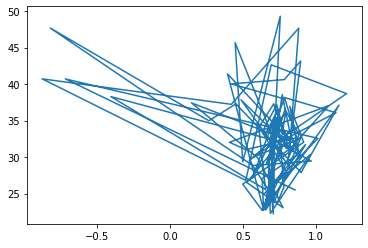

In [10]:
nb_samples = 100
sio2_gen = np.random.random_sample(nb_samples)

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

na2o_gen = (R_MAl*reminder)*(1.0-R_XK)
k2o_gen = (R_MAl*reminder)*(R_XK)

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
X_rec = X_gen.copy()
X_gen = torch.Tensor(X_gen.values).to(device)

Cpconf = neuralmodel.ap_calc(X_gen) + neuralmodel.b_calc(X_gen)* neuralmodel.tg(X_gen)

Cp_S = Cpconf/neuralmodel.sctg(X_gen)



# train-test split
#X_train, X_valid = model_selection.train_test_split(X_gen, test_size=0.30, random_state=42)]

plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(X_gen).cpu().detach().numpy())
    
    
    
#    y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(x_entro_train).cpu().detach().numpy(),"ks")

(array([ 2.,  1.,  0.,  5.,  6., 10., 20., 26., 16., 14.]),
 array([-3.3391662, -3.2102168, -3.0812674, -2.9523177, -2.8233683,
        -2.694419 , -2.5654695, -2.43652  , -2.3075705, -2.178621 ,
        -2.0496716], dtype=float32),
 <a list of 10 Patch objects>)

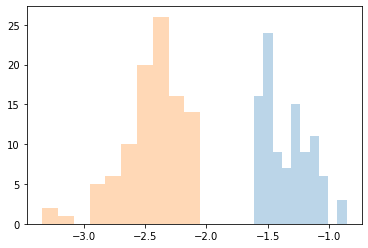

In [11]:
plt.hist(neuralmodel.a_am(X_gen).cpu().detach().numpy(),alpha=0.3)
plt.hist(neuralmodel.ae(X_gen).cpu().detach().numpy(),alpha=0.3)

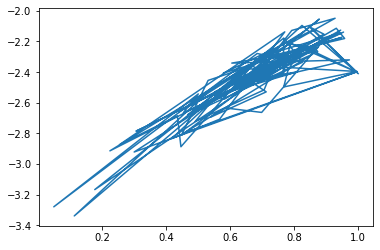

In [12]:
plt.plot(X_rec.sio2+X_rec.al2o3,neuralmodel.ae(X_gen).cpu().detach().numpy())

In [0]:
neuralmodel.ae

Parameter containing:
tensor([-1.7462], device='cuda:0', requires_grad=True)